# NAOC SIMULATION

### Characteristics of the Program:

1. **Modular Structure:** Employing a modular structure, the code organizes multiple classes, including `OnlineSolver`, `Observer`, `CriticNN`, `ActorNN`, `Controller`, and `Sim1`. This design enhances code readability and maintainability.

2. **Object-Oriented Design:** The code adheres to object-oriented programming (OOP) principles by defining classes and their methods. This approach facilitates encapsulation of related functionalities within classes, improving code organization and reusability.

3. **TensorFlow Usage:** TensorFlow is utilized for defining and manipulating tensors, constructing neural networks (e.g., RBFNN), and implementing online solvers.

4. **OnlineSolver:** The `OnlineSolver` class serves as a generic entity for updating states based on a state reducer function, showcasing its applicability in various iterative algorithms.

5. **Observer:** Implemented within the `Observer` class, an observer for a control system includes an observer state reducer, an execution method, and other pertinent functionalities.

6. **CriticNN and ActorNN:** These classes form integral components of an actor-critic architecture, commonly employed in reinforcement learning. They involve the definition of neural networks, learning rates, and other parameters.

7. **Controller:** The `Controller` class represents a controller, equipped with methods for predicting control actions based on state variables.

8. **Simx:** The `Simx` class is designed for simulating a system with a specific state reducer. It encompasses the updating of the state based on a control input, subsequently returning the state and output.

9. **Documentation:** The code incorporates comments and docstrings, providing valuable information about the purpose and usage of classes and functions. This enhances code readability and facilitates collaboration.

10. **Configuration Parameters:** Parameters such as learning rates, forgetting rates, and other coefficients have been introduced to allow flexibility and customization of the control system.

The code also includes a simulation scenario using the NAOC (Nonlinear Adaptive Observer and Controller) framework. It utilizes various classes and parameters to simulate a control system, providing visualizations of system states, observer estimates, and other relevant metrics over time. The simulation involves iterative steps, updating the control system based on observed states and feedback mechanisms.

Note: The provided code assumes the existence of specific classes and functions (e.g., `Observer`, `Controller`, `ActorNN`, `CriticNN`, `Sim1`) and dependencies (e.g., TensorFlow, NumPy, Matplotlib) that are not explicitly defined in the provided snippet. The actual implementation of these components is crucial for the code's functionality.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

In [3]:
from naocnp.observer import Observer
from naocnp.controller import Controller
from naocnp.actornn import ActorNN
from naocnp.criticnn import CriticNN
from sim1 import Sim1

In [4]:
L = (1, 150)
C = (1, 0)
Bn = (0, 1)
nstages = 2
solver_step = 1e-2

observer_learning_rate = .1
observer_forgetting_rate = 10
observer_rbfnn_input_dim_vector=[1, 2]
observer_rbfnn_output_dim_vector=1
observer_rbfnn_num_centers_vector=5
observer_rbfnn_sigma_vector=3
observer_rbfnn_input_intervals_vector=[
    [(0, 1)], 
    [(0, 1), (-2, 2)]
    ]
q_state_error = [1, 1]
r_control_effort = [5, 1]
kb_constraint = [0.6, 3]
actor_learning_rate = [10, 2]
critic_learning_rate = [20, 5]
actor_rbfnn_num_centers_vector=9
actor_rbfnn_sigma_vector=2
actor_rbfnn_input_intervals_vector=[
    [(-0.06, 0.06)], 
    [(-0.06, 0.06)]
    ]
critic_rbfnn_num_centers_vector=9
critic_rbfnn_sigma_vector=3
critic_rbfnn_input_intervals_vector=[
    [(-6, 6)], 
    [(-6, 6)]
    ]
eta = [1, 10]
eta_bar = [50, 50]
x_hat_int = [0.01, 0]
x_int = [0.5, 0]


In [5]:
observer = Observer(
    L=L,
    C=C,
    Bn=Bn,
    learning_rate=observer_learning_rate,
    forgetting_rate=observer_forgetting_rate,
    rbfnn_input_dim_vector=observer_rbfnn_input_dim_vector,
    rbfnn_output_dim_vector=observer_rbfnn_output_dim_vector,
    rbfnn_num_centers_vector=observer_rbfnn_num_centers_vector,
    rbfnn_sigma_vector=observer_rbfnn_sigma_vector,
    rbfnn_input_intervals_vector=observer_rbfnn_input_intervals_vector,
    x_init=x_hat_int,
    solver_step=solver_step,
)

In [6]:
actornn = ActorNN(
    q=q_state_error,
    r=r_control_effort,
    kb=kb_constraint,
    learning_rate=actor_learning_rate,
    observer=observer,
    rbfnn_num_centers_vector=actor_rbfnn_num_centers_vector,
    rbfnn_input_intervals_vector=actor_rbfnn_input_intervals_vector,
    rbfnn_sigma_vector=actor_rbfnn_sigma_vector,
    solver_step=solver_step,
)

In [7]:
criticnn = CriticNN(
    q=q_state_error,
    r=r_control_effort,
    kb=kb_constraint,
    learning_rate=critic_learning_rate,
    eta=eta,
    eta_bar=eta_bar,
    rbfnn_num_centers_vector=critic_rbfnn_num_centers_vector,
    rbfnn_input_intervals_vector=critic_rbfnn_input_intervals_vector,
    rbfnn_sigma_vector=critic_rbfnn_sigma_vector,
    observer=observer,
    actornn=actornn,
    solver_step=solver_step,
)
actornn.set_criticnn(criticnn)

In [8]:
controller = Controller(
    actornn=actornn,
    eta=eta,
    eta_bar=eta_bar,
    r=r_control_effort,
    kb=kb_constraint,
)

In [9]:
system = Sim1(x_int=x_int, solver_step=solver_step)

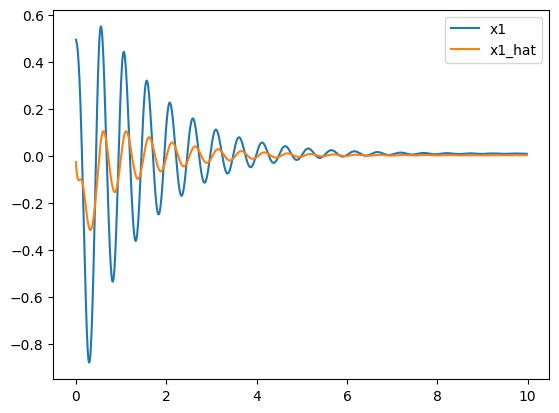

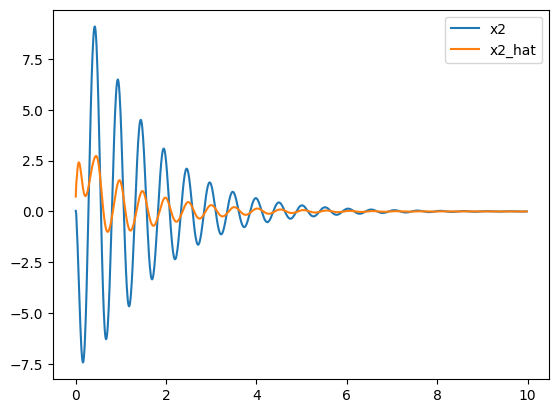

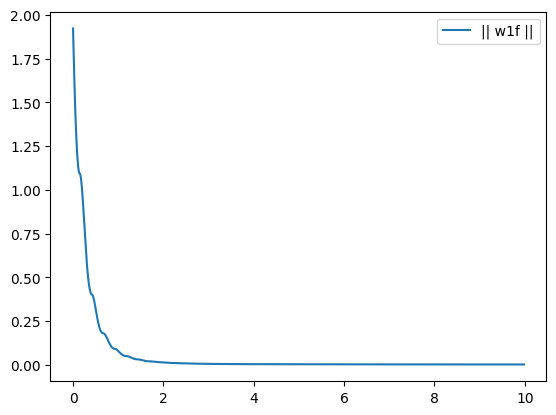

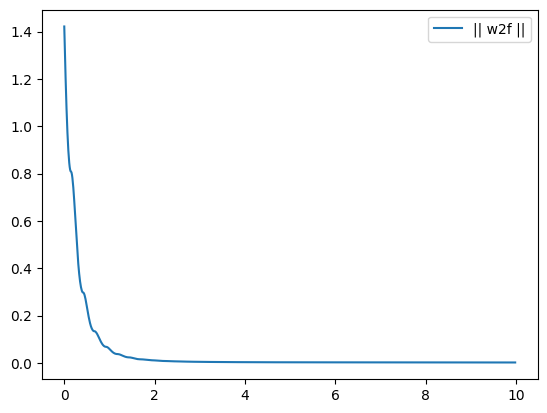

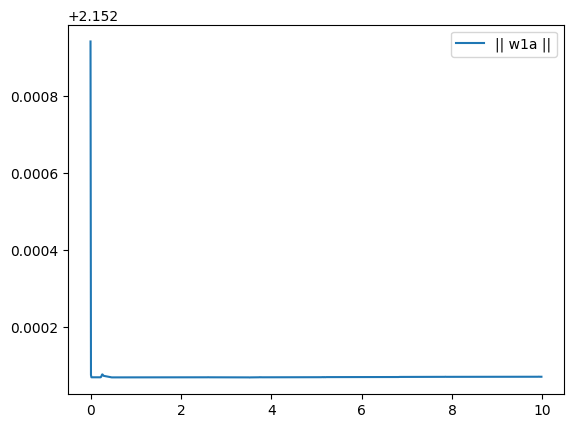

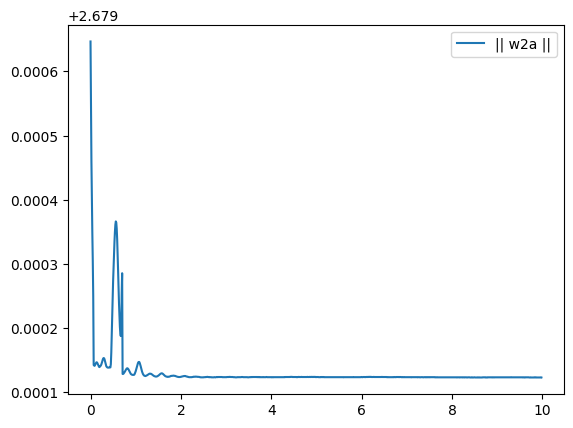

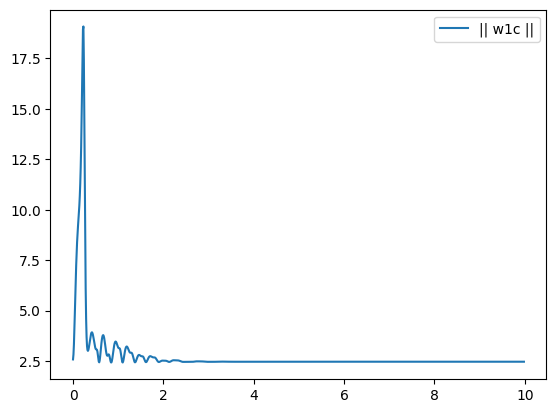

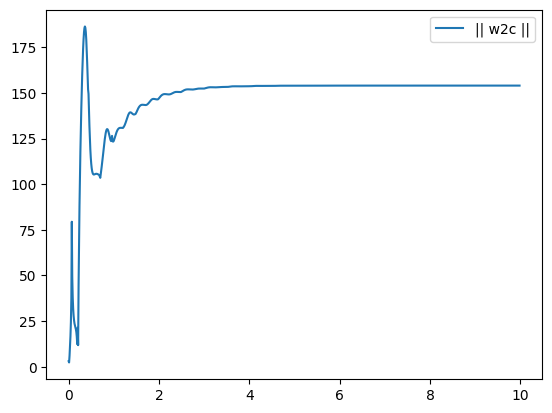

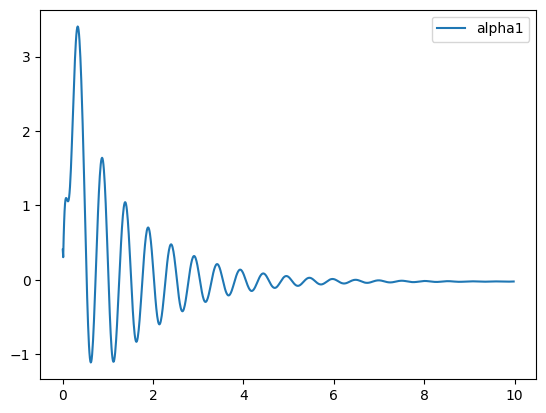

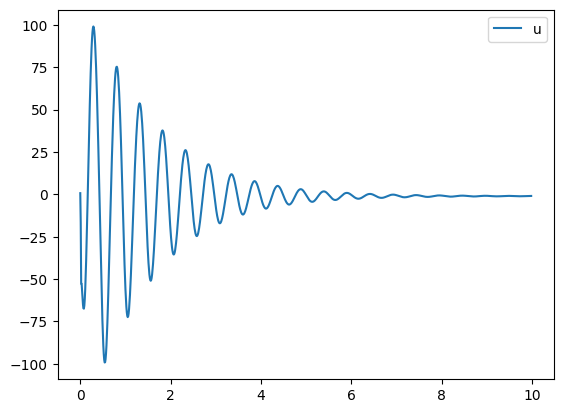

In [10]:
# Parameters
sim_duration = 10  # Duration of simulation
num_steps = int(sim_duration / solver_step)
batch_size = 100
s = None


# Arrays to store simulation data
simulation_time = np.arange(0, sim_duration, solver_step)
shape = simulation_time.shape
x1_data = np.zeros(shape=shape)
x2_data = np.zeros(shape=shape)
x1_hat_data = np.zeros(shape=shape)
x2_hat_data = np.zeros(shape=shape)
w1f_data = np.zeros(shape=shape)
w2f_data = np.zeros(shape=shape)
w1a_data = np.zeros(shape=shape)
w2a_data = np.zeros(shape=shape)
w1c_data = np.zeros(shape=shape)
w2c_data = np.zeros(shape=shape)
alpha1_data = np.zeros(shape=shape)
u_data = np.zeros(shape=shape)


#  figure and axis for plotting
figx1, ax1 = plt.subplots()
figx2, ax2 = plt.subplots()
figw1f, aw1f = plt.subplots()
figw2f, axw2f = plt.subplots()
figw1a, axw1a = plt.subplots()
figw2a, axw2a = plt.subplots()
figw1c, axw1c = plt.subplots()
figw2c, axw2c = plt.subplots()
figwalp1, axalp1 = plt.subplots()
figu, axu = plt.subplots()

ax_list = [ax1, ax2, aw1f, axw2f, axw1a, axw2a, axw1c, axw2c, axalp1, axu]
fig_list = [figx1,figx2,figw1f,figw2f,figw1a,figw2a,figw1c,figw2c,figwalp1,figu]
[(ax.set_xlabel('Time'), ax.set_ylabel('State')) for ax in ax_list]

j = 0
i_base = 0
# Main simulation loop
for i in range(num_steps):
    # t0 = time.time()
    # simulation step execution
    control_vct = controller(s)
    x, y = system.exec(control_vct[-1, 0])
    x_hat, y_hat = observer(y, control_vct[-1, 0])
    s = observer.error_surface(control_vct)

    criticnn.update(s, control_vct, y, y_hat)
    actornn.update(s, control_vct, y, y_hat)
    # t1 = time.time()
    
    # Store simulation data
    x1, x2 = x.numpy().flatten()
    x1_hat, x2_hat = x_hat.numpy().flatten()
    
    w1f, w2f = observer.rbfnn_vector[0].weights, observer.rbfnn_vector[1].weights
    w1a, w2a = actornn.rbfnn_vector[0].weights, actornn.rbfnn_vector[1].weights
    w1c, w2c = criticnn.rbfnn_vector[0].weights, criticnn.rbfnn_vector[1].weights
    
    w1f, w2f = tf.norm(w1f), tf.norm(w2f)
    w1a, w2a = tf.norm(w1a), tf.norm(w2a)
    w1c, w2c = tf.norm(w1c), tf.norm(w2c)
    alpa1, u = control_vct[0, 0], control_vct[1, 0]
    # print(f"w1f: {w1f}, w2f: {w2f}")
    # print(f"w1a: {w1a}, w2a: {w2a}")
    # print(f"w1c: {w1c}, w2c: {w2c}")
    

    x1_data[j] = x1
    x2_data[j] = x2
    x1_hat_data[j] = x1_hat
    x2_hat_data[j] = x2_hat
    w1f_data[j] = w1f
    w2f_data[j] = w2f
    w1a_data[j] = w1a
    w2a_data[j] = w2a
    w1c_data[j] = w1c
    w2c_data[j] = w2c
    alpha1_data[j] = alpa1
    u_data[j] = u
    j += 1

    if not (j % batch_size):
        # Plot
        [(ax.clear()) for ax in ax_list]
        ax1.plot(simulation_time[:i], x1_data[:i], label='x1')
        ax1.plot(simulation_time[:i], x1_hat_data[:i], label='x1_hat')
        ax2.plot(simulation_time[:i], x2_data[:i], label='x2')
        ax2.plot(simulation_time[:i], x2_hat_data[:i], label='x2_hat')
        aw1f.plot(simulation_time[:i], w1f_data[:i], label='|| w1f ||')
        axw2f.plot(simulation_time[:i], w2f_data[:i], label='|| w2f ||')
        axw1a.plot(simulation_time[:i], w1a_data[:i], label='|| w1a ||')
        axw2a.plot(simulation_time[:i], w2a_data[:i], label='|| w2a ||')
        axw1c.plot(simulation_time[:i], w1c_data[:i], label='|| w1c ||')        
        axw2c.plot(simulation_time[:i], w2c_data[:i], label='|| w2c ||')
        axalp1.plot(simulation_time[:i], alpha1_data[:i], label='alpha1')        
        axu.plot(simulation_time[:i], u_data[:i], label='u')
        [(ax.legend()) for ax in ax_list]

        clear_output(wait=True)
        [display(fig) for fig in fig_list]
        plt.pause(0.001)  # Pause to update the plot
        i_base = i + 1

plt.close()
